Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [29]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30
2,3.0,4.0,2541.0,6059.0,4975.0,NaN,96958.0,2003.0,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01
3,2.0,3.0,1650.0,6037.0,7300.0,NaN,96037.0,1949.0,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01
4,1.0,2.0,693.0,6037.0,2908.0,NaN,96023.0,1921.0,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29


In [4]:
# check DF tail
df.tail()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14985,3.0,5.0,2526.0,6059.0,7800.0,1.0,97018.0,1994.0,33753643.0,-117766503.0,458903.0,5718.72,2017-06-30
14986,3.0,5.0,2735.0,6059.0,7100.0,1.0,97067.0,1963.0,33783173.0,-117817799.0,115387.0,1465.88,2017-06-30
14987,2.0,3.0,1536.0,6037.0,8818.0,1.0,96523.0,1955.0,34058178.0,-117948180.0,297097.0,3519.78,2017-06-30
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [16]:
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270
2,3.0,4.0,2541.0,6059,4975,0,96958,2003,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01,0.011153
3,2.0,3.0,1650.0,6037,7300,0,96037,1949,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01,0.012497
4,1.0,2.0,693.0,6037,2908,0,96023,1921,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29,0.011915


In [11]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
fips_codes = pd.read_clipboard()

In [19]:
Rename fips_codes columns
fips_codes = fips_codes.rename(columns ={'1001': 'code', 'Autauga':'County', 'AL': 'State'})

In [20]:
fips_codes.head()

,code,County,State
0,1003,Baldwin,AL
1,1005,Barbour,AL
2,1007,Bibb,AL
3,1009,Blount,AL
4,1011,Bullock,AL


In [23]:
#merge df and fips_codes 
df = pd.merge(df, fips_codes, left_on='fips', right_on='code', how='left')

In [24]:
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,code,County,State
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,6037,Los Angeles,CA
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,6037,Los Angeles,CA
2,3.0,4.0,2541.0,6059,4975,0,96958,2003,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01,0.011153,6059,Orange,CA
3,2.0,3.0,1650.0,6037,7300,0,96037,1949,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01,0.012497,6037,Los Angeles,CA
4,1.0,2.0,693.0,6037,2908,0,96023,1921,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29,0.011915,6037,Los Angeles,CA


In [ ]:
#create a subset of df with continuous variables to create pairplot

In [38]:
df_plot = df[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [39]:
df_plot.head()

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
0,2.0,3.0,1458.0,8284,136104.0
1,1.0,2.0,1421.0,6707,35606.0
2,3.0,4.0,2541.0,4975,880456.0
3,2.0,3.0,1650.0,7300,614000.0
4,1.0,2.0,693.0,2908,274237.0


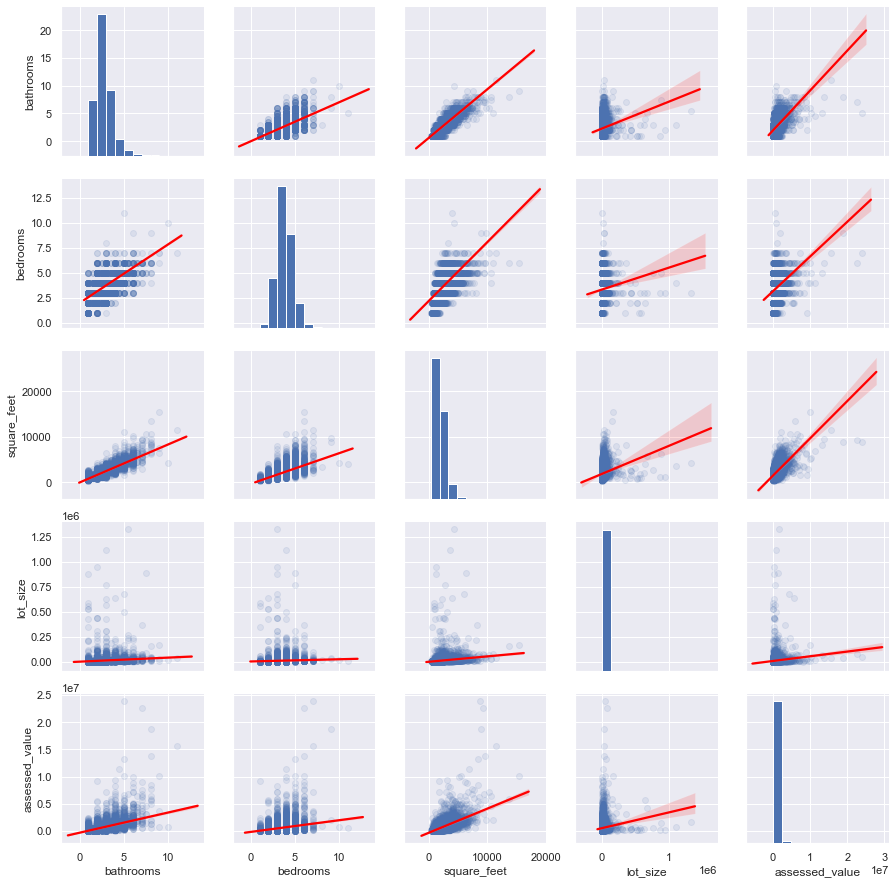

In [40]:
explore.plot_variable_pairs(df_plot)

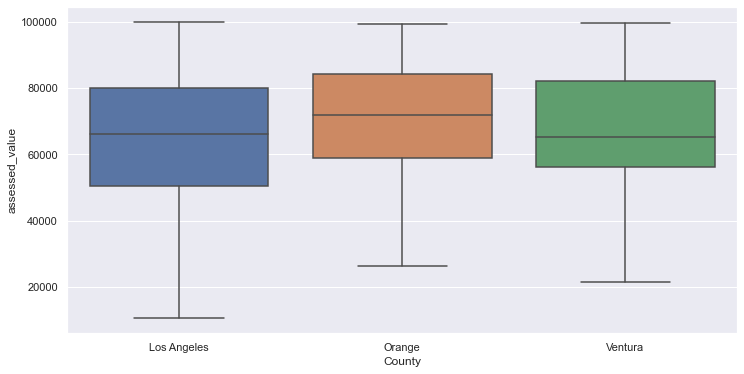

In [50]:
plt.figure(figsize=(12,6))
sns.boxplot(x= df[df.assessed_value<100000].County, y= df[df.assessed_value<100000].assessed_value, data=df[df.assessed_value<100000])

In [43]:
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,code,County,State
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,6037,Los Angeles,CA
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,6037,Los Angeles,CA
2,3.0,4.0,2541.0,6059,4975,0,96958,2003,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01,0.011153,6059,Orange,CA
3,2.0,3.0,1650.0,6037,7300,0,96037,1949,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01,0.012497,6037,Los Angeles,CA
4,1.0,2.0,693.0,6037,2908,0,96023,1921,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29,0.011915,6037,Los Angeles,CA


In [44]:
df.assessed_value.mean()

539641.5195992738

In [45]:
df.assessed_value.median()

384643.0

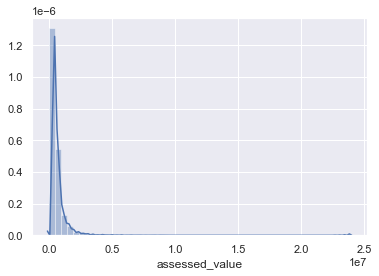

In [46]:
sns.distplot(df.assessed_value)

In [47]:
df[df.assessed_value>1000000]

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,code,County,State
44,6.0,5.0,3540.0,6037,2435,0,96109,1953,33859142.0,-118399597.0,8000000.0,83955.53,2017-05-01,0.010494,6037,Los Angeles,CA
56,3.5,3.0,4511.0,6059,11440,0,96957,2008,33590049.0,-117863575.0,5422228.0,57183.30,2017-05-01,0.010546,6059,Orange,CA
64,7.5,5.0,6278.0,6111,889495,1,97091,1998,34257434.0,-118872795.0,1389230.0,15101.52,2017-05-01,0.010870,6111,Ventura,CA
86,3.5,4.0,2802.0,6059,3746,0,96954,2014,33687210.0,-117753270.0,1074416.0,14637.34,2017-05-01,0.013624,6059,Orange,CA
113,5.5,3.0,4361.0,6111,1323788,1,97118,1999,34237200.0,-118807351.0,1562700.0,17692.72,2017-05-01,0.011322,6111,Ventura,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14775,4.5,4.0,4808.0,6059,14133,1,96989,1998,33637201.0,-117582676.0,1820000.0,18855.16,2017-06-30,0.010360,6059,Orange,CA
14795,4.0,4.0,4137.0,6037,17981,1,96321,1947,34169679.0,-118263112.0,1018400.0,11284.93,2017-06-30,0.011081,6037,Los Angeles,CA
14800,2.0,2.0,1986.0,6037,6801,1,96412,1927,34148134.0,-118449841.0,1289366.0,15616.54,2017-06-30,0.012112,6037,Los Angeles,CA
14810,3.5,4.0,3257.0,6059,11210,0,96978,2011,33657653.0,-117884031.0,1432404.0,15143.22,2017-06-30,0.010572,6059,Orange,CA
